In [1]:
# Data processing and visualization libs
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from collections import Counter

# Web scraping libs
import time
import requests
from bs4 import BeautifulSoup
import re

In [2]:
def get_chart(trend_df, change_df, title_df, chart_dates, root_url):
    # Generate all chart url links
    full_url = [root_url + date for date in chart_dates]
    for i in range(len(full_url)):
        root_html = requests.get(full_url[i])
        root_bs = BeautifulSoup(root_html.text, 'html.parser')
        # Get the exact chart number of each song
        chart_index = [int(n.get_text()) - 1 for n in root_bs.find_all(class_ = 'chart-element__rank__number')]
        if len(chart_index) == 100:
            trend = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = re.compile('^chart-element__trend chart-element__trend'))], index = range(100))
            change = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = 'chart-element__information__delta__text text--default')], index = range(100))
            title = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = 'chart-element__information__song text--truncate color--primary')], index = range(100))
            artist = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = 'chart-element__information__artist text--truncate color--secondary')], index = range(100))
            trend_df[chart_dates[i]] = trend
            change_df[chart_dates[i]] = change
            title_df[chart_dates[i]] = title + [' - ']*100 + artist
            print('{w} is finished with {n} entries.'.format(w = chart_dates[i], n = [len(trend), len(change), len(title)]))
            time.sleep(5)
        elif (len(chart_index) < 100) & (len(chart_index) > 90):
            # Remove possible dulplicated chart numbers (I suppose the ranking method is: 1, 2 ,3, 3, 5 instead of 1, 2, 3, 3, 4)
            chart_index = [chart_index[0]] + [m + 1 if m == n else m for n, m in zip(chart_index[:-1], chart_index[1:])]
            trend = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = re.compile('^chart-element__trend chart-element__trend'))], index = chart_index)
            change = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = 'chart-element__information__delta__text text--default')], index = chart_index)
            trend = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = 'chart-element__information__song text--truncate color--primary')], index = chart_index)
            change = pd.Series([trend.get_text() for trend in root_bs.find_all(class_ = 'chart-element__information__artist text--truncate color--secondary')], index = chart_index)
            trend_df[chart_dates[i]] = trend
            change_df[chart_dates[i]] = change
            title_df[chart_dates[i]] = title + [' - ']*len(chart_index) + artist
            print('{w} is finished with {n} entries.'.format(w = chart_dates[i], n = [len(trend), len(change), len(title)]))
            time.sleep(5)
        else:
            trend_df[chart_dates[i]] = np.nan
            change_df[chart_dates[i]] = np.nan
            title_df[chart_dates[i]] = np.nan
            print('[Warning] {w} has {n} entries.'.format(w = chart_dates[i], n = [len(chart_index)]))

In [3]:
# Generate all the chart dates in HOT 100 history.
# The earliest available date is 1958-08-04 and the second earliest date is 1958-08-09. After that, the chart updates weekly regularly.  
chart_dates = list(pd.date_range(start = '1958-08-02', end = '2020-02-01', freq='7d').astype('str'))
root_url = 'https://www.billboard.com/charts/hot-100/'

# trend_df = pd.DataFrame(index = range(100))
# change_df = pd.DataFrame(index = range(100))
# title_df = pd.DataFrame(index = range(100))

trend_df = pd.read_csv('trend_df.csv')
change_df = pd.read_csv('change_df.csv')
title_df = pd.read_csv('title_df.csv')

# Week 1976-11-27 missed No. 45 on chart, Week 1977-01-22 has two No. 18 on chart, Week 1978-08-13 has two No. 66 on chart but the next two numbers are 67, 69
# get_chart(trend_df, change_df, title_df, chart_dates, root_url)

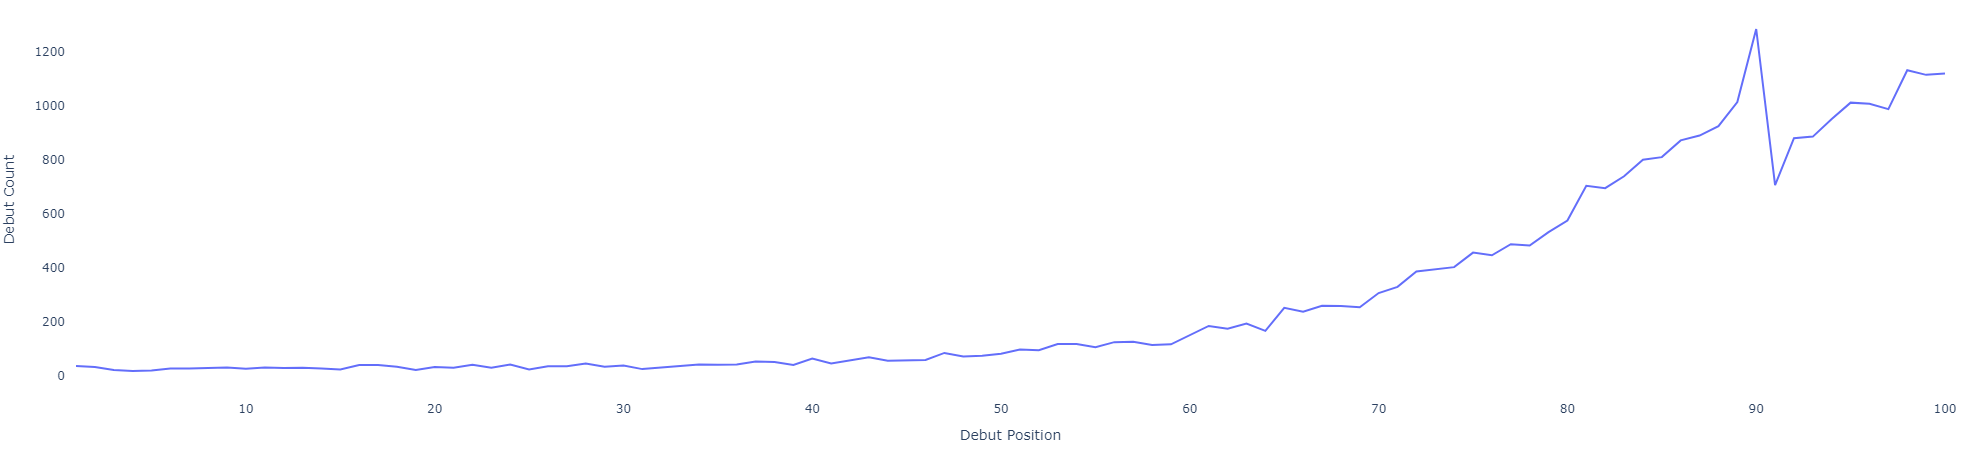

In [4]:
fig = go.Figure(go.Scatter(x=(trend_df == 'New').sum(axis = 1).index + 1,
                           y=(trend_df == 'New').sum(axis = 1),
                           mode='lines',
                           name='lines'))
fig.update_layout(width=1000, 
                  height=450, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Debut Position",
                  yaxis_title="Debut Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

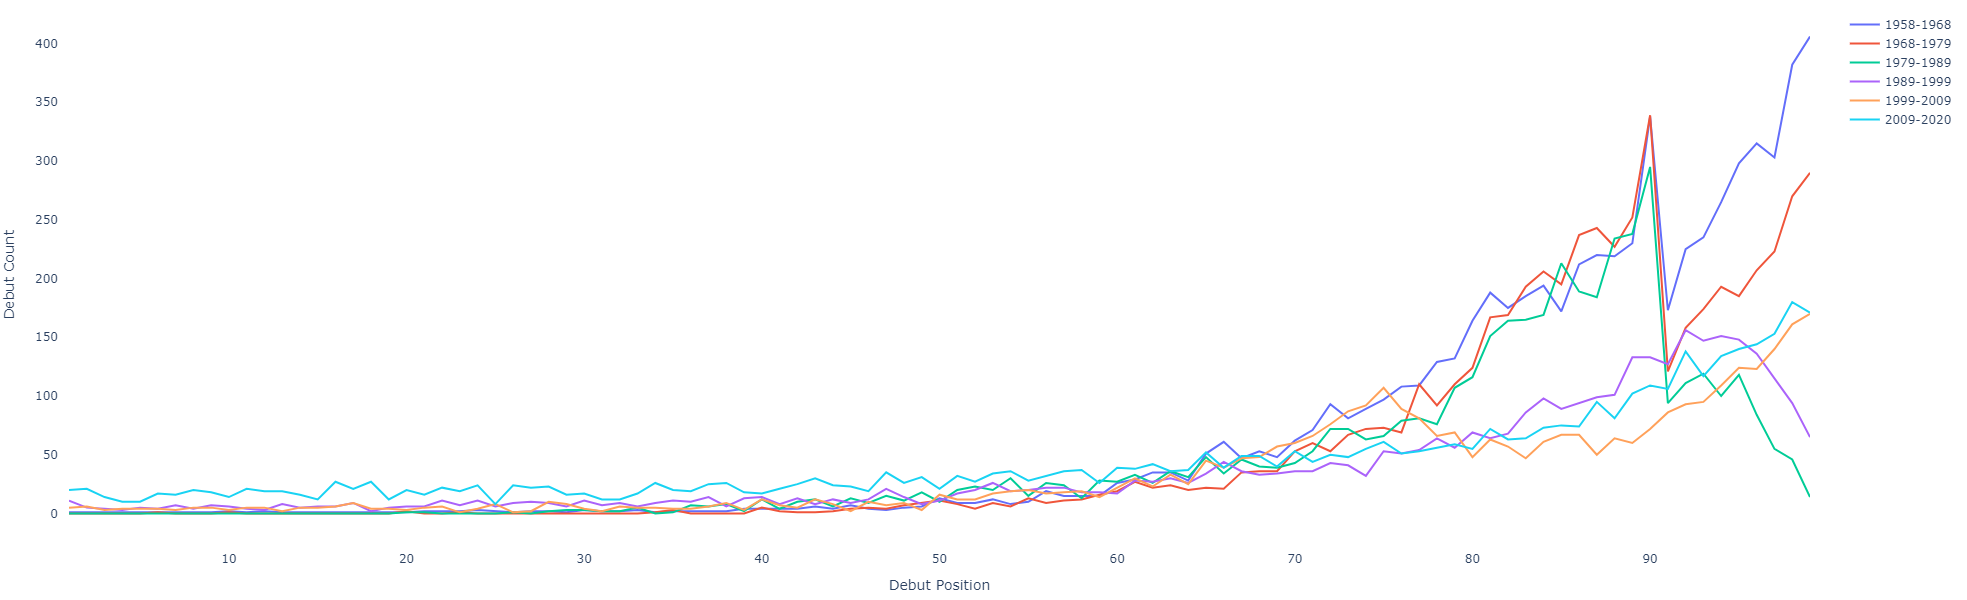

In [5]:
fig = go.Figure()
for i in range(0, len(trend_df.columns), 535):
    fig.add_trace(go.Scatter(x=list(range(1, 100)),
                             y=(trend_df == 'New').iloc[:, i:(i+535)].sum(axis = 1),
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=600, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Debut Position",
                  yaxis_title="Debut Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

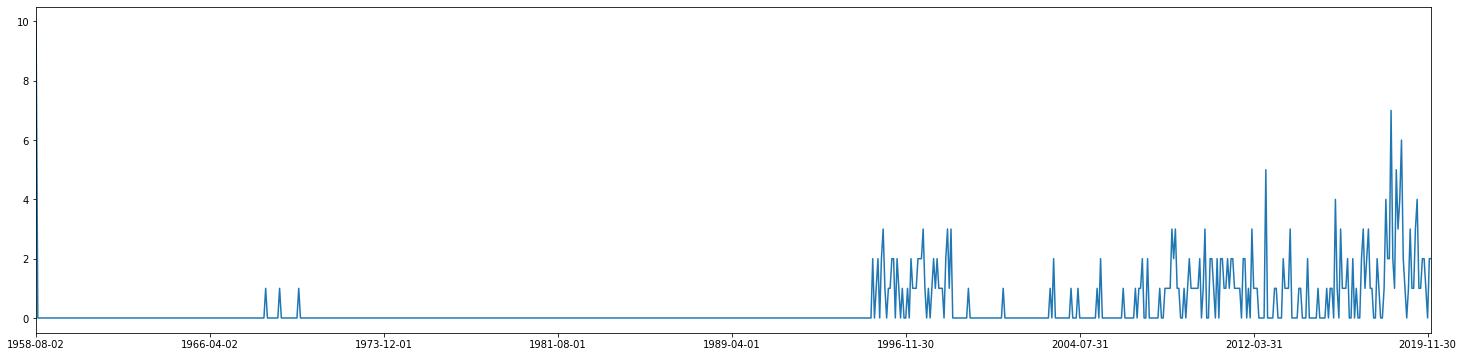

In [8]:
c1w_li = list((trend_df.loc[0:9, :] == 'New').sum())
c4w_li = [sum(c1w_li[w:(w+4)]) for w in range(0, len(c1w_li), 4)]
c4w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%4 == 0]
c4w_se = pd.Series(c4w_li, index = c4w_da).plot(figsize = (25, 6))

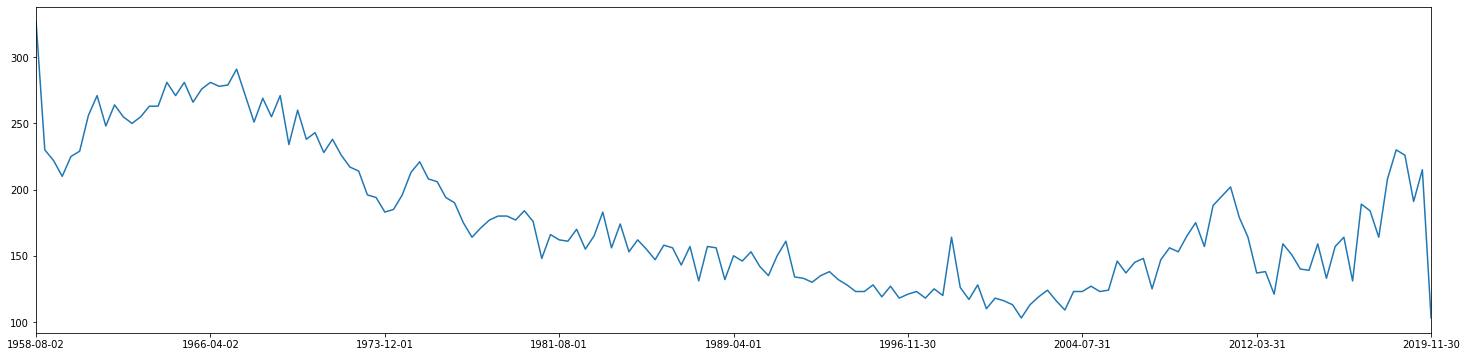

In [163]:
c1w_li = list((trend_df.loc[:, :] == 'New').sum())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

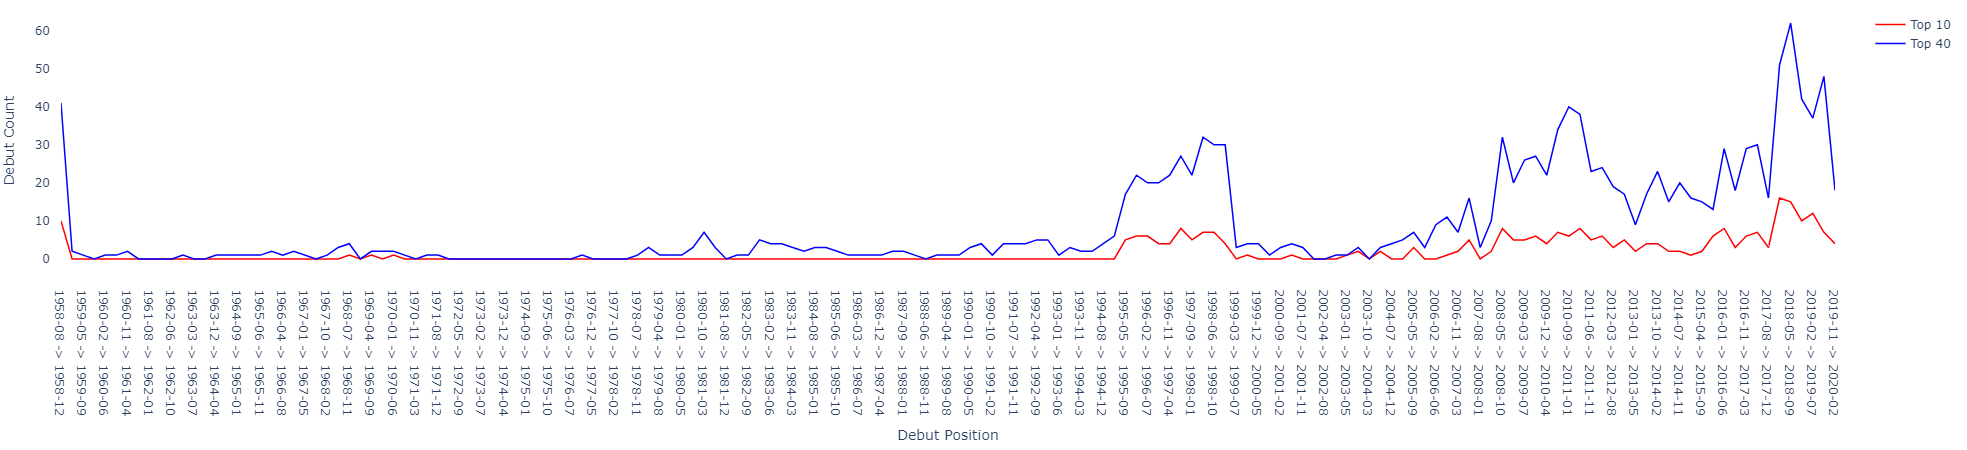

In [8]:
fig = go.Figure()
c1w_li = list((trend_df.loc[0:9, :] == 'New').sum())
fig.add_trace(go.Scatter(x=[chart_dates[d][:7] + ' -> ' + chart_dates[min(d+19, len(trend_df.columns) - 1)][:7] for d in range(len(c1w_li)) if d%20 == 0],
                         y=[sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)],
                         line=dict(color = 'red', width = 1.5),
                         name='Top 10'))
c1w_li = list((trend_df.loc[0:39, :] == 'New').sum())
fig.add_trace(go.Scatter(x=[chart_dates[d][:7] + ' -> ' + chart_dates[min(d+19, len(trend_df.columns) - 1)][:7] for d in range(len(c1w_li)) if d%20 == 0],
                         y=[sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)],
                         line=dict(color = 'blue', width = 1.5),
                         name='Top 40'))
fig.update_layout(width=1000, 
                  height=450, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Debut Position",
                  yaxis_title="Debut Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

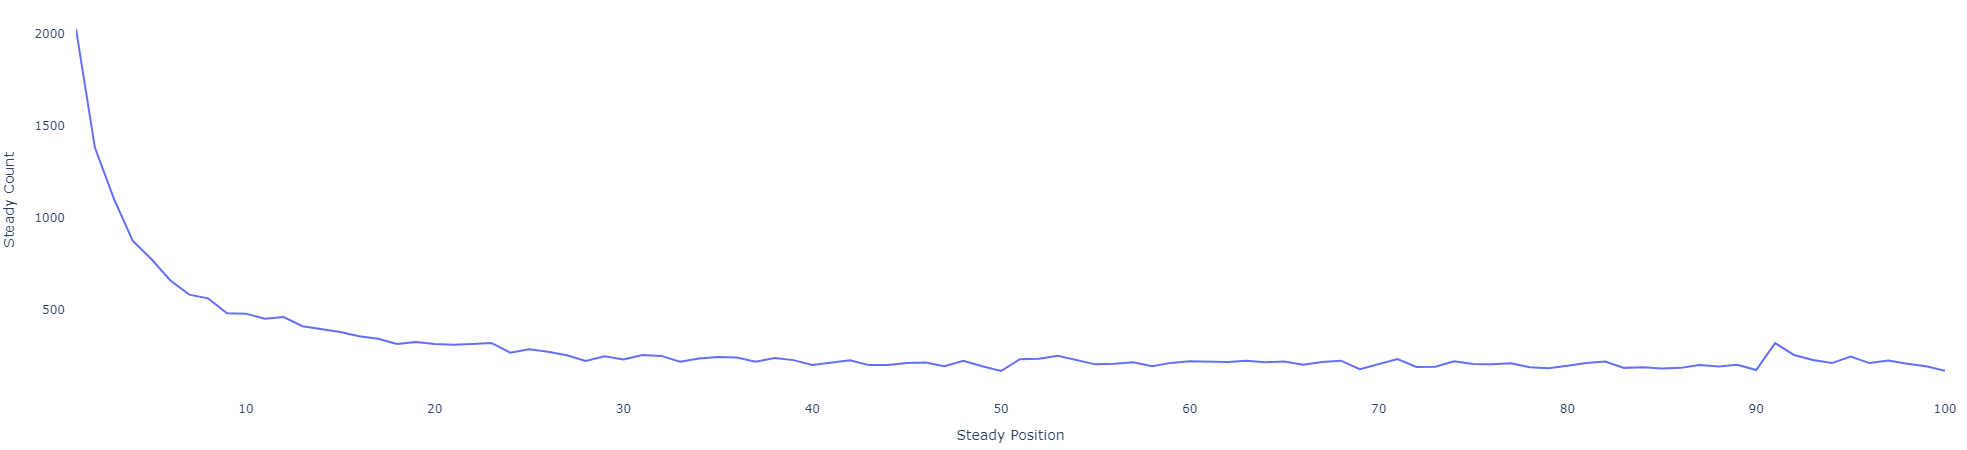

In [9]:
fig = go.Figure(go.Scatter(x=(trend_df == 'Steady').sum(axis = 1).index + 1,
                           y=(trend_df == 'Steady').sum(axis = 1),
                           mode='lines',
                           name='lines'))
fig.update_layout(width=1000, 
                  height=450, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Steady Position",
                  yaxis_title="Steady Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

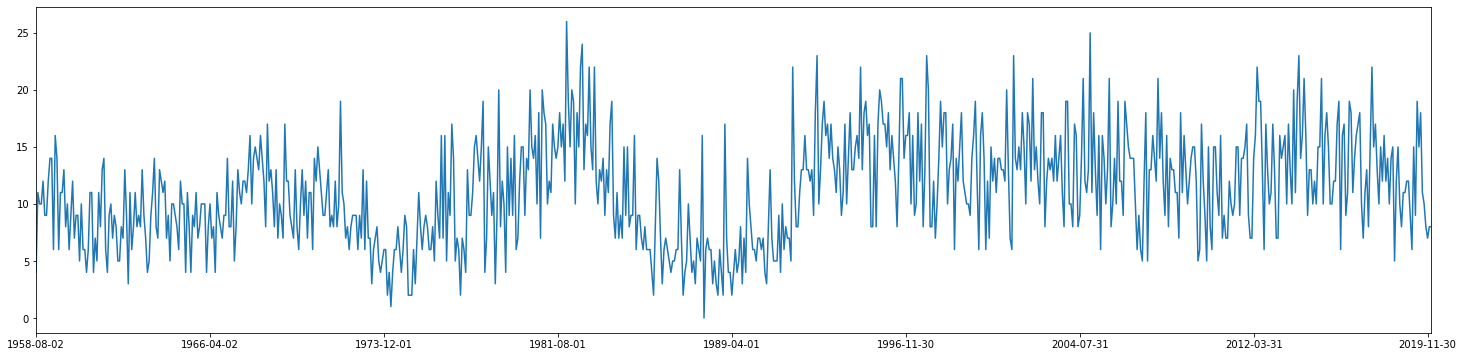

In [11]:
c1w_li = list((trend_df.loc[0:9, :] == 'Steady').sum())
c4w_li = [sum(c1w_li[w:(w+4)]) for w in range(0, len(c1w_li), 4)]
c4w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%4 == 0]
c4w_se = pd.Series(c4w_li, index = c4w_da).plot(figsize = (25, 6))

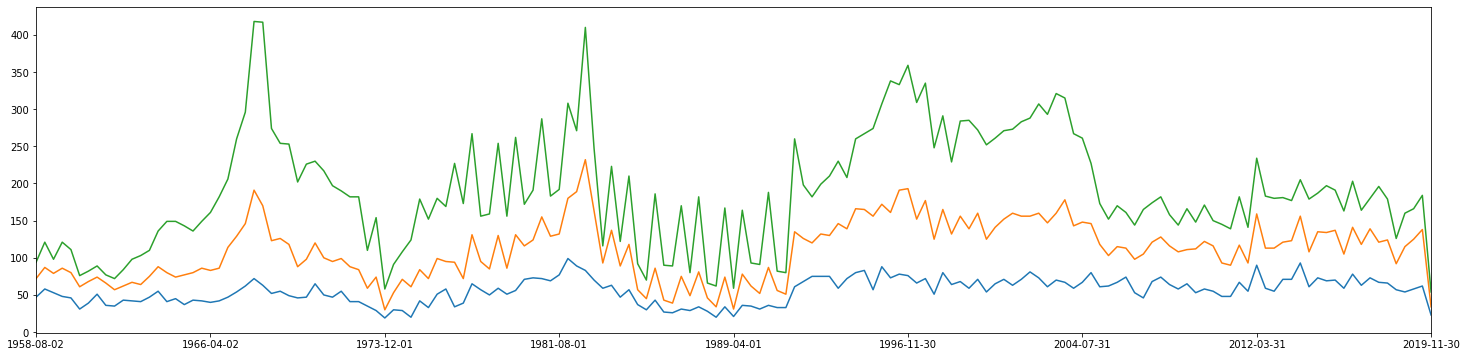

In [157]:
c1w_li = list((trend_df.loc[0:9, :] == 'Steady').sum())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

c1w_li = list((trend_df.loc[0:39, :] == 'Steady').sum())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

c1w_li = list((trend_df.loc[:, :] == 'Steady').sum())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

In [27]:
c10y_steady_df = pd.DataFrame([(trend_df == 'Steady').iloc[:, x:(x+535)].sum(axis = 1) for x in range(0, len(trend_df.columns), 535)]).transpose()
c10y_steady_df.columns = [chart_dates[d] for d in range(len(trend_df.columns)) if d%535 == 0]

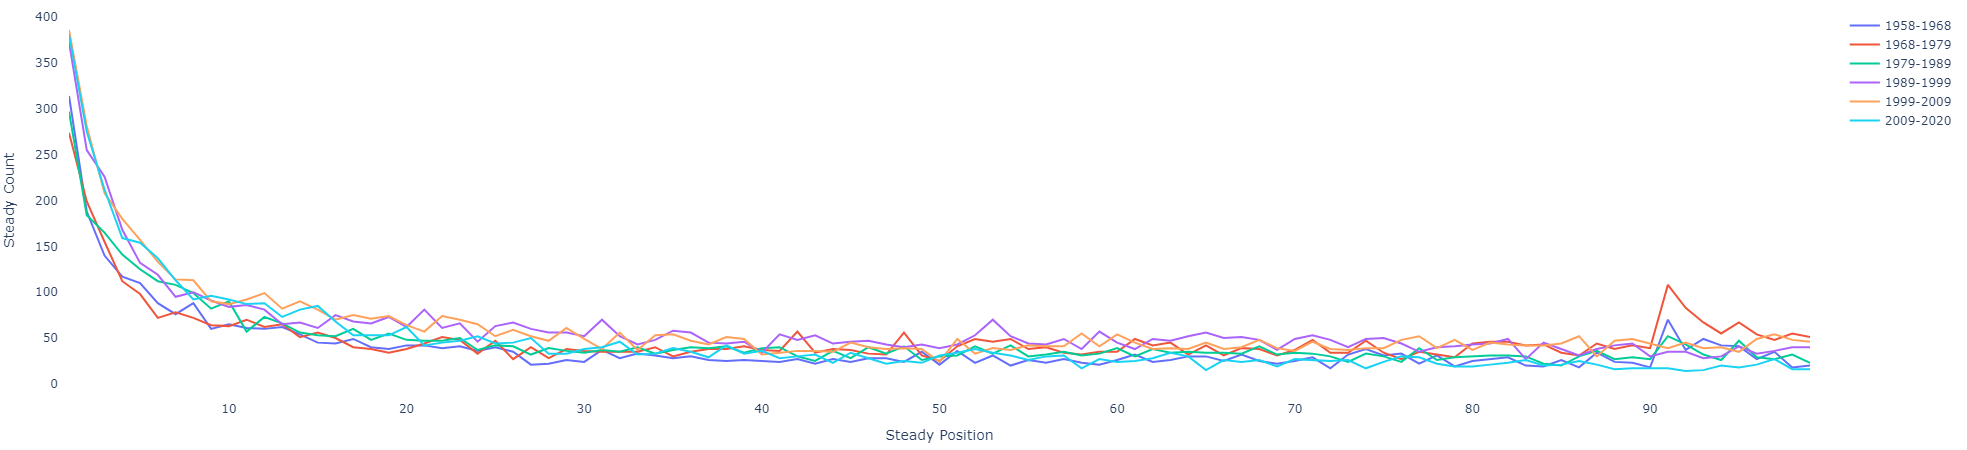

In [11]:
fig = go.Figure()
for i in range(0, len(trend_df.columns), 535):
    fig.add_trace(go.Scatter(x=list(range(1, 100)),
                             y=(trend_df == 'Steady').iloc[:, i:(i+535)].sum(axis = 1),
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=450, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Steady Position",
                  yaxis_title="Steady Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

In [158]:
trend_df.columns[(trend_df == 'Steady').sum() > 40]

Index(['1977-01-01', '1977-12-31', '1978-12-30', '1979-12-29', '1981-01-03',
       '1982-01-02', '1983-01-01', '1983-12-31', '1984-12-29', '1986-01-04',
       '1987-01-03', '1988-01-02', '1988-12-31', '1989-12-30', '1990-12-29',
       '1991-12-28'],
      dtype='object')

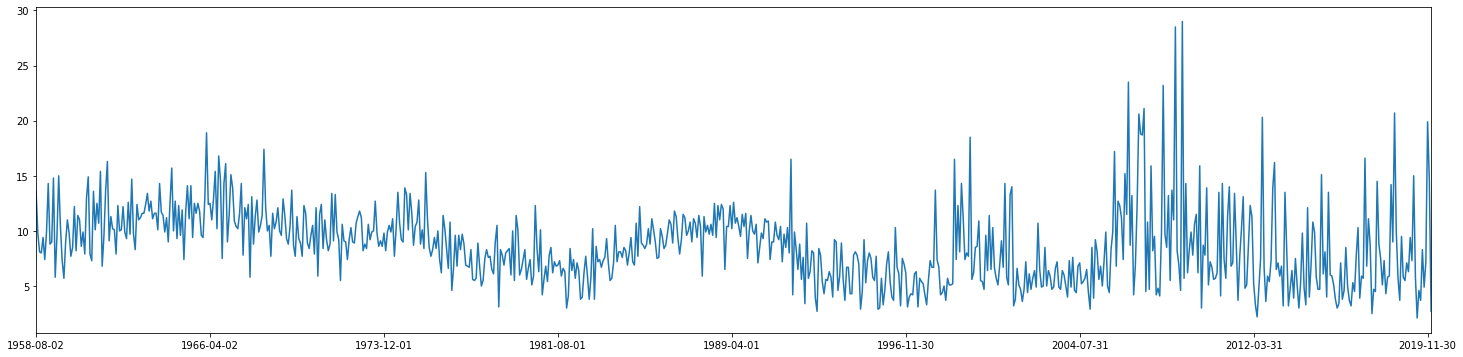

In [16]:
c1w_li = list(abs(change_df.loc[0:9, :].replace('-', 0).fillna(0).astype('int')).mean())
c4w_li = [sum(c1w_li[w:(w+4)]) for w in range(0, len(c1w_li), 4)]
c4w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%4 == 0]
c4w_se = pd.Series(c4w_li, index = c4w_da).plot(figsize = (25, 6))

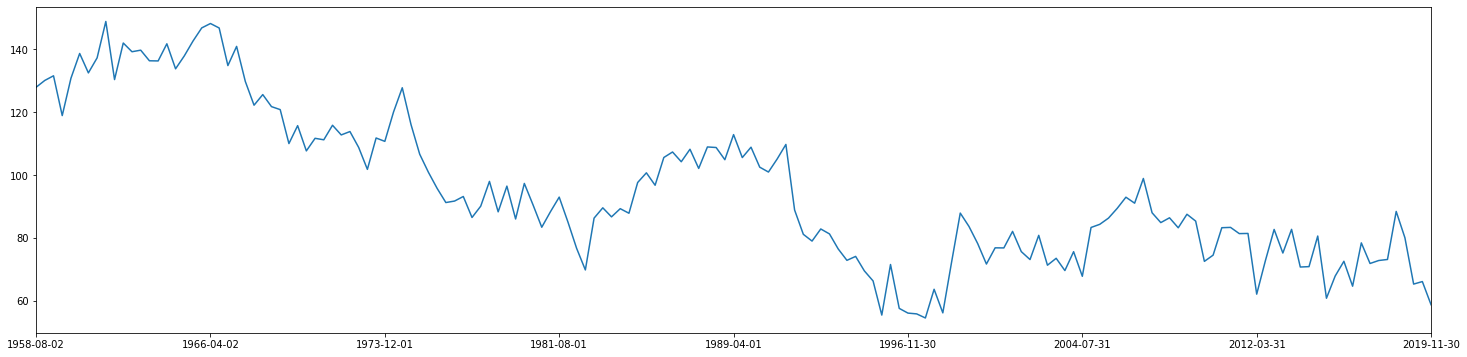

In [17]:
c1w_li = list(abs(change_df.loc[0:39, :].replace('-', 0).fillna(0).astype('int')).mean())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

In [18]:
change_new_df = change_df.replace('-', 0).fillna(0).astype('int') + trend_df.apply(lambda x: [m*n for m,n in zip([y == 'New' for y in x], [100 - r for r in range(100)])])

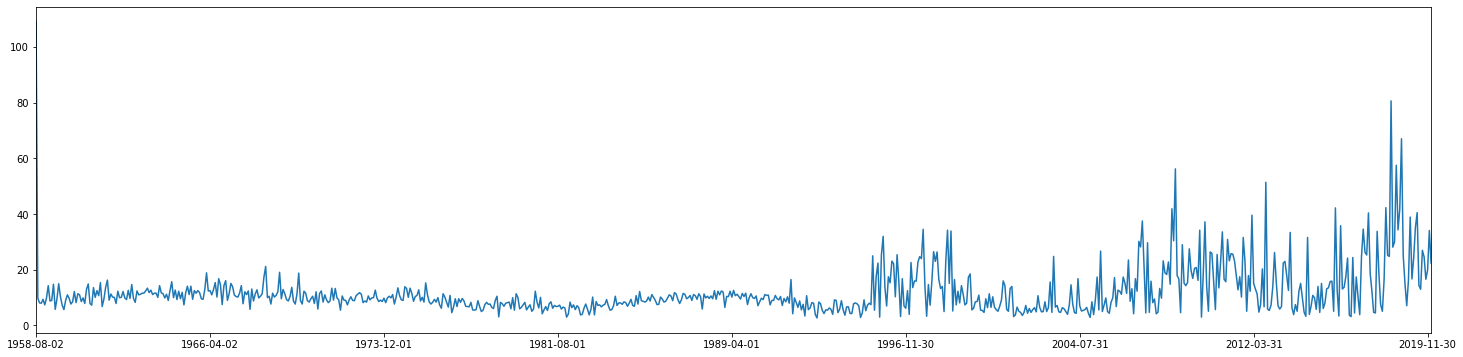

In [19]:
c1w_li = list(abs(change_new_df.loc[0:9, :]).mean())
c4w_li = [sum(c1w_li[w:(w+4)]) for w in range(0, len(c1w_li), 4)]
c4w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%4 == 0]
c4w_se = pd.Series(c4w_li, index = c4w_da).plot(figsize = (25, 6))

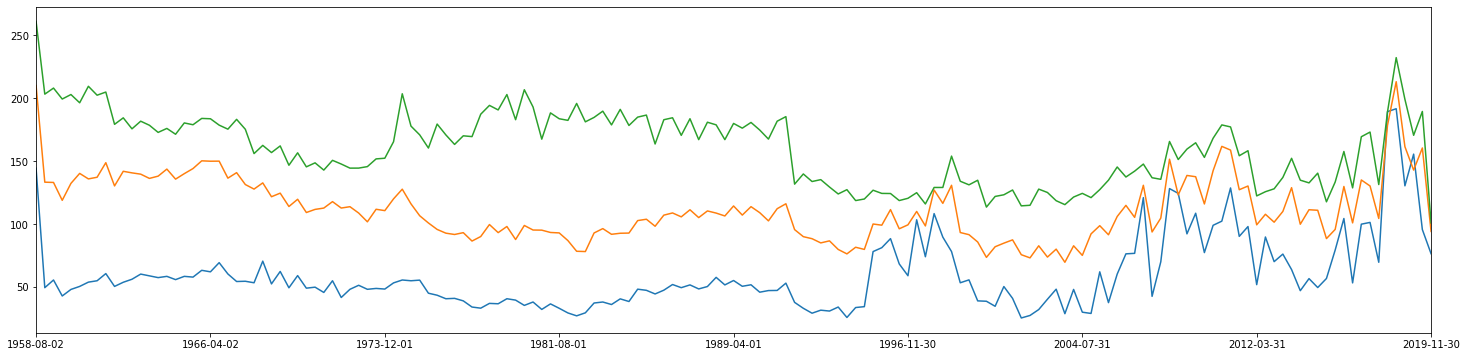

In [159]:
c1w_li = list(abs(change_new_df.loc[0:9, :]).mean())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

c1w_li = list(abs(change_new_df.loc[0:39, :]).mean())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

c1w_li = list(abs(change_new_df.loc[:, :]).mean())
c20w_li = [sum(c1w_li[w:(w+20)]) for w in range(0, len(c1w_li), 20)]
c20w_da = [chart_dates[d] for d in range(len(c1w_li)) if d%20 == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

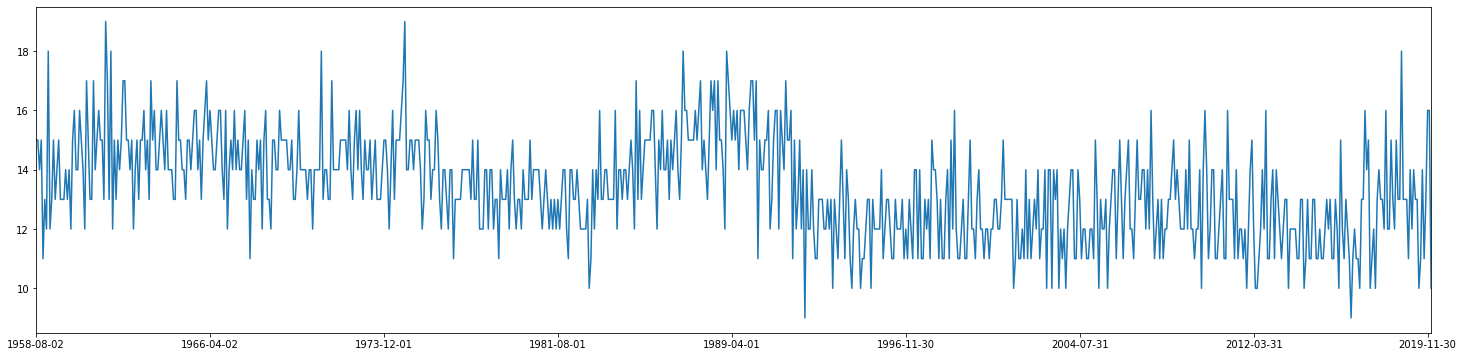

In [43]:
c4w_li = [len(set([l2 for l1 in title_df.iloc[0:9, w:(w+4)].values for l2 in l1])) for w in range(0, len(title_df.columns), 4)]
c4w_da = [chart_dates[d] for d in range(len(title_df.columns)) if d%4 == 0]
c4w_se = pd.Series(c4w_li, index = c4w_da).plot(figsize = (25, 6))

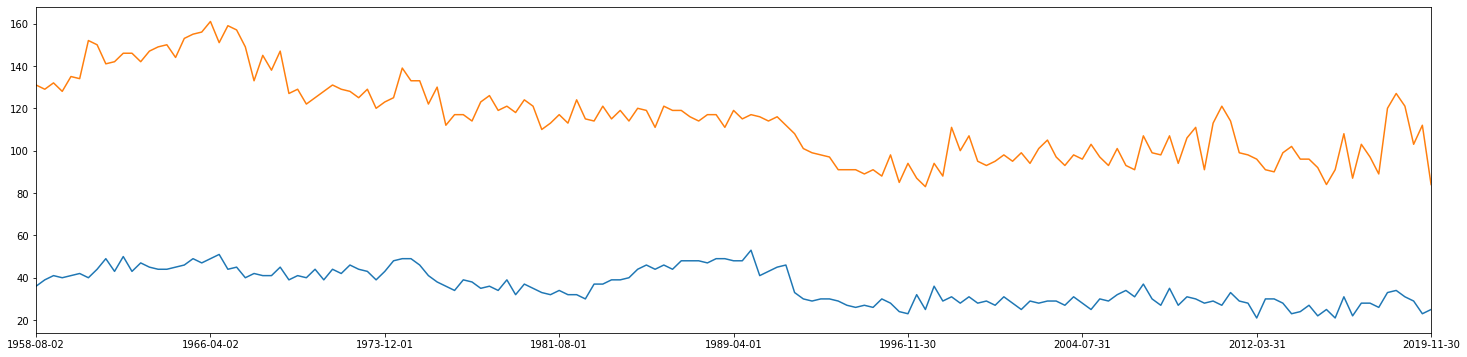

In [161]:
n = 20
c20w_li = [len(set([l2 for l1 in title_df.iloc[0:9, w:(w+n)].values for l2 in l1])) for w in range(0, len(title_df.columns), n)]
c20w_da = [chart_dates[d] for d in range(len(title_df.columns)) if d%n == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

c20w_li = [len(set([l2 for l1 in title_df.iloc[0:39, w:(w+n)].values for l2 in l1])) for w in range(0, len(title_df.columns), n)]
c20w_da = [chart_dates[d] for d in range(len(title_df.columns)) if d%n == 0]
c20w_se = pd.Series(c20w_li, index = c20w_da).plot(figsize = (25, 6))

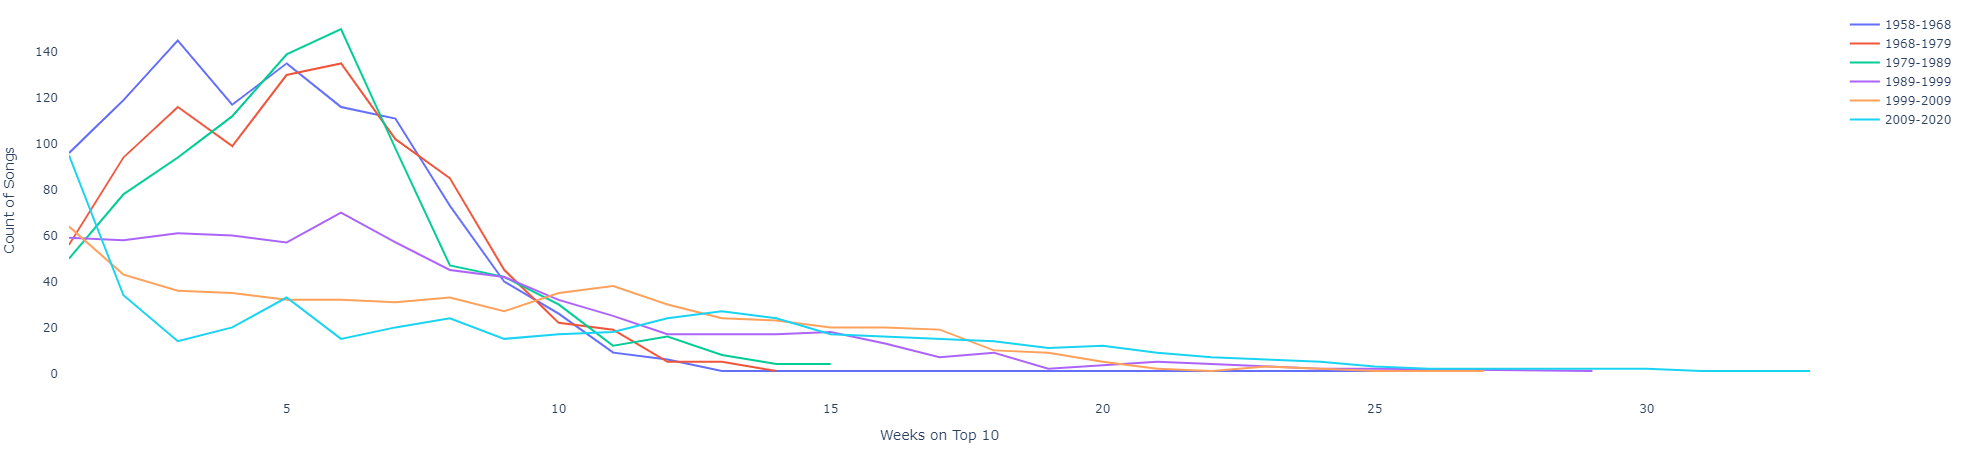

In [12]:
fig = go.Figure()
for i in range(0, len(title_df.columns), 535):
    dct = Counter(Counter([l2 for l1 in title_df.iloc[0:9, i:(i + 535)].values for l2 in l1]).values())
    dct_x = list(dct.keys())
    dct_x.sort()
    fig.add_trace(go.Scatter(x=dct_x,
                             y=[dct.get(i) for i in dct_x],
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=450, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Weeks on Top 10",
                  yaxis_title="Count of Songs",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()